## Data606 - Capstone Project
```
Group H
Malav Patel, Kent Butler
Prof. Unal Sokaglu
```

This project is about performing time-series analysis on climate data analysis data.



# Research

### References

Some explanations of earth sciences statistics:
https://pjbartlein.github.io/REarthSysSci/ltms-and-anomalies.html

NOAA PSL NCEP-NCAR datasets:  https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html

NOAA PSL, other recognized data sources directory: https://psl.noaa.gov/data/help/othersources/

Global environmental policy timeline, https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline

OECD convergence of policy, climate,and economy: https://www.oecd.org/

NASA climate time machine: https://climate.nasa.gov/interactives/climate-time-machine

### Factoids

* All of the plastic waste produced in the world in 2019 alone weighs as much as 35,000 Eiffel Towers – 353 million tons  - [*Organization for Economic Cooperation and Development (OECD)*](https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline)



## Application Parameters

Note: algorithm tuning is done with declaration of the model.

In [2]:
import pandas as pd
from datetime import datetime as dt
import datetime

In [3]:
debug = True

DRIVE_PATH = "/content/drive/MyDrive/data606"

# Set the location of this script in GDrive
SCRIPT_PATH = DRIVE_PATH + "/src/"

# Root Path of the data on the cloud drive
DATA_ROOT = DRIVE_PATH + "/data/"

# Model to use
MODEL_NAME = 'Densev1'
#MODEL_NAME = 'TXERv1'
# MODEL_NAME = 'LSTMv3'

# Location of logged output prediction data
LOG_PATH = DATA_ROOT + "/preds/"

# Journal file
JOURNAL_LOG = SCRIPT_PATH + "cv-results.csv"

# Device to run on
run_on_device =  'cpu' # 'cuda'

# Bound datasets by these dates
START_DATE =  pd.to_datetime(dt.fromisoformat('1950-01-01'))
END_DATE = pd.to_datetime(dt.fromisoformat('2015-12-01'))
# These work for Berkely temp data
#START_DATE =  pd.to_datetime(dt.fromisoformat('1950-01-01'))
#END_DATE = pd.to_datetime(dt.fromisoformat('2015-12-01'))



---

**Model Configuration**

---

**Basic model params**

In [4]:
# History lookback in network
INPUT_WINDOW = 60
# How far forward to predict
LABEL_WINDOW = 48
# How many to move forward for start of next label
SHIFT = 5
# Ratio of test data to train data - used for split
TEST_RATIO = 0.2
# 0..1 percent of data to use as validation
VALIDATION_RATIO = 0.1
# Num epochs
NUM_EPOCHS = 300

**Configure Predictions**

In [5]:
# Label to predict
TARGET_LABEL = 'storm_type'
TARGET_LABELS = ['storm_type']
#TARGET_LABEL = 'landSeaAvgTemp'
#TARGET_LABELS = ['landSeaAvgTemp']

# Base dataset
TEMP_DATA = {'filename':'GlobalTemperatures.csv',
             'feature_map':{'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
             'date_col':'dt'}
#TEMP_DATA = {'filename':'GlobalTemperatures.csv',
#              'feature_map':{'LandAverageTemperature':'landAvgTemp',	'LandMaxTemperature':'landMaxTemp',	'LandMinTemperature':'landMinTemp',	'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
#               'date_col':'dt'}


# Datasets
CO2_DATA = {'filename':"atmospheric-co2.csv",
            'feature_map':{'Carbon Dioxide (ppm)':'co2', 'Seasonally Adjusted CO2 (ppm)':'co2_seas'},
            'date_map':{'Year':'year','Month':'month'}}

SEAICE_DATA = {'filename':"seaice.csv",
               'feature_map':{'     Extent':'ice_extent'},
               'date_map':{' Month':'month','Year':'year',' Day':'day'}}

WEATHER_DATA = {'filename':"finalDatasetWithRain.csv",
                'feature_map':{'air_x':'air_x','uwnd_y':'uwind','pres_x.1':'press','vwnd_y':'vwind','rain':'rain'},
                'date_col':'time'}

VOLCANO_DATA = {'filename':'eruptions-conditioned.csv',
                'feature_map':{'vei':'volcanic_idx'},
                'date_map':{'start_year':'year','start_month':'month'}}

FOREST_DATA = {'filename':'WorldForestCover-Interpolated.csv',
               'feature_map':{'PctCover-Int':'pct_forest_cover'},
               'date_col':'date'}

SUNSPOT_DATA = {'filename':'sunspotnumber.csv',
               'feature_map':{'suns_spot_number':'sunspot_num'},
               'date_map':{'year':'year'}}

POLICY_DATA = {'filename':'GlobalEnvPolicies.csv',
               'feature_map':{'EventRating':'policy_rate'},
               'date_col':'date'}

HURRICANE_DATA = {'filename':'nhc.noaa.gov-dates-processed.csv',
                  'feature_map':{'type_code':'storm_type'},
                  #'feature_map':{'lat_deg':'lat', 'long_deg':'long', 'type_code':'storm_type'},
                  'date_col':'dateobj'}

CARIBE_TEMP_DATA = {'filename':'GlobalLandTemperaturesByCity-caribe.csv',
                     'feature_map':{'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
                   'date_col':'dt'}

#GHG_DATA = {'filename':'greenhouse_gas_inventory_data.csv',
#            'feature_map':{''},
#            'date_map':{'Year':'year'}}


#ALL_DATASETS = []
#ALL_DATASETS = [SUNSPOT_DATA]
ALL_DATASETS = [WEATHER_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, VOLCANO_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA, FOREST_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA, CO2_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA, CO2_DATA, SEAICE_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]
#ALL_DATASETS = [WEATHER_DATA,CO2_DATA, SEAICE_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]

#ALL_DATASETS = [POLICY_DATA,CO2_DATA]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd $SCRIPT_PATH

/content/drive/MyDrive/data606/src


In [8]:
# Load util class
%run -i "./ProjectUtil.ipynb"

In [9]:
# Load util class
%run -i "./WindowGenerator.ipynb"

              A   B      C
2011-01-02   97   1  0.125
2011-01-03   98   2  0.250
2011-01-04   99   3  0.375
2011-01-05  100   4  0.500
2011-01-06  101   5  0.625
2011-01-07  102   6  0.750
2011-01-08  103   7  0.875
2011-01-09  104   8  1.000
2011-01-10  105   9  1.125
2011-01-11  106  10  1.250
2011-01-12  107  11  1.375
2011-01-13  108  12  1.500
2011-01-14  109  13  1.625
2011-01-15  110  14  1.750
2011-01-16  111  15  1.875
2011-01-17  112  16  2.000
2011-01-18  113  17  2.125
2011-01-19  114  18  2.250
2011-01-20  115  19  2.375
2011-01-21  116  20  2.500
2011-01-22  117  21  2.625
2011-01-23  118  22  2.750
Shape: (22, 3)
--- Case 1 ------
 input_width=None, label_width=1, shift=1, label_columns=['A']
Correct outcome - assert error
--- Case 2 ------
 input_width=4, label_width=1, shift=1, label_columns=['A']
Window Generator::
	Input size: 4
	Label size: 1
	Shift: 1
	Batch size: 4
	Total window size: 5
	Label start: 4
input_arr: (22, 2)
label_arr: (22, 1)
Frames: (18, 4, 2)
First

# Data Load

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)
import warnings

In [11]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

---

**Initial Data Load**

---

In [12]:
# Load util class
%run -i "./Dataset_Merger.ipynb"

In [13]:
# Declare a merger compatible with our source data and our target dataset we want to merge into
merger = Dataset_Merger(data_path=DATA_ROOT, start_date=START_DATE, end_date=END_DATE, debug=True)

In [14]:
initial_dataset = HURRICANE_DATA  #TEMP_DATA

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/nhc.noaa.gov-dates-processed.csv

 ### Defaulting df_aggr to reference df
------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22307 entries, 0 to 22306
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  22307 non-null  int64  
 1   date        22307 non-null  int64  
 2   hour        22307 non-null  int64  
 3   code        22307 non-null  object 
 4   type        22307 non-null  object 
 5   lat         22307 non-null  object 
 6   long        22307 non-null  object 
 7   max_winds   22307 non-null  int64  
 8   press       22307 non-null  int64  
 9   dateobj     22307 non-null  object 
 10  lat_quad    22307 non-null  object 
 11  long_quad   22307 non-null  object 
 12  lat_deg     2

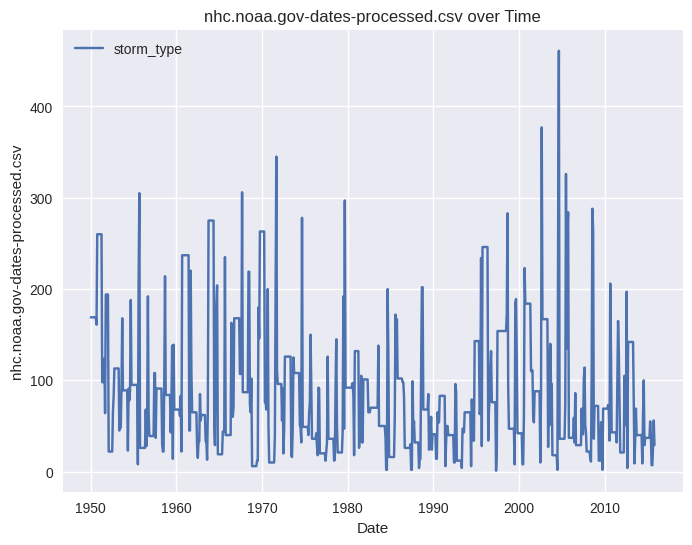

------------------------------------------
 ### assess_granularity for cols: ['storm_type']
 ### After grouping y/m/d: 791
 ### After grouping y/m: 791
 ### After grouping y: 66
Dataset assessed at timestep freq: M


In [15]:
# Start by merging initial dataset
df_merge = merger.merge_dataset(initial_dataset['filename'],
                                initial_dataset['feature_map'],
                                 date_col=initial_dataset['date_col'],
                                 add_cyclic=True,
                                 scaling_aggr='sum')

# And store an indication of what our step scale is
cols = list(initial_dataset['feature_map'].values())
STEP_FREQ = merger.assess_granularity(df_merge, cols)

In [16]:
print(assess_na(df_merge))

  _date_  day year month storm_type day-sin day-cos
0    0.0  0.0  0.0   0.0        0.0     0.0     0.0


---

**Merge Additional Data**

---

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/finalDatasetWithRain.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622392 entries, 0 to 622391
Data columns (total 71 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   lat       622392 non-null  float64
 1   lon       622392 non-null  float64
 2   time      622392 non-null  object 
 3   air_x     622392 non-null  float64
 4   air_y     311196 non-null  float64
 5   air       0 non-null       float64
 6   lftx4     311196 non-null  float64
 7   cfnlf     622392 non-null  float64
 8   cfnsf     622392 non-null  float64
 9   pres_x    321908 non-null  float64
 10  pres_y    321908 non-null  float64
 11  pres_x.1  488723 non-null  float64
 12  pres_y.1  488718 non-null  float64
 13  pres_x.2  390709 non-null  float6

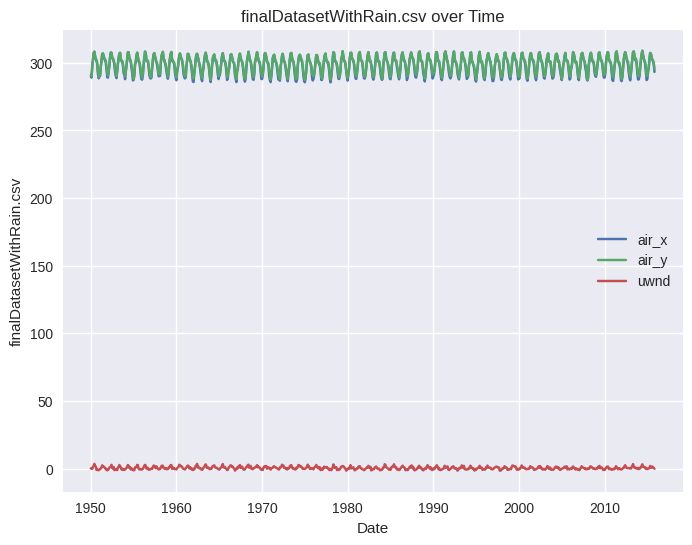

  _date_  day year month storm_type day-sin day-cos air_x air_y uwnd
0    0.0  0.0  0.0   0.0        0.0     0.0     0.0   0.0   0.0  0.0
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/atmospheric-co2.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               720 non-null    int64  
 1   month                              720 non-null    int64  
 2   Decimal Date                       720 non-null    float64
 3   co2                                703 non-null    float64
 4   co2_seas                           703 non-null    float64
 5   Carbon Dioxide Fit (ppm)           707 non-null    float64


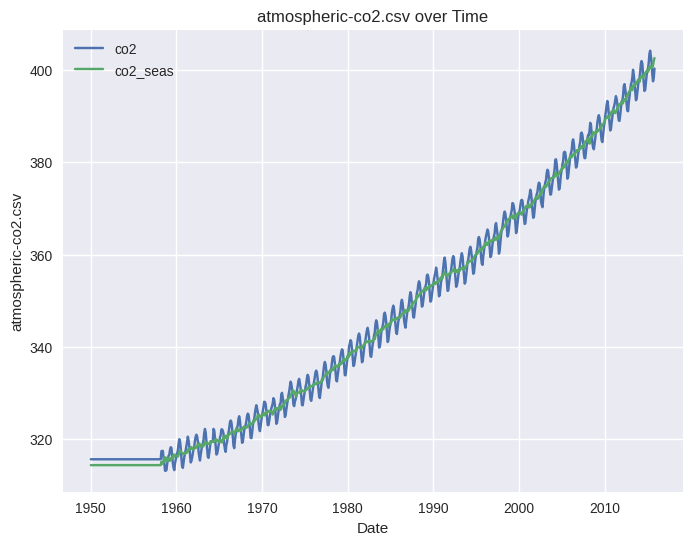

  _date_  day year month storm_type day-sin day-cos air_x air_y uwnd  co2  \
0    0.0  0.0  0.0   0.0        0.0     0.0     0.0   0.0   0.0  0.0  0.0   

  co2_seas  
0      0.0  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/seaice.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26354 entries, 0 to 26353
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          26354 non-null  int64  
 1   month         26354 non-null  int64  
 2   day           26354 non-null  int64  
 3   ice_extent    26354 non-null  float64
 4   ice_missing   26354 non-null  float64
 5    Source Data  26354 non-null  object 
 6   hemisphere    26354 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB
-------------------------

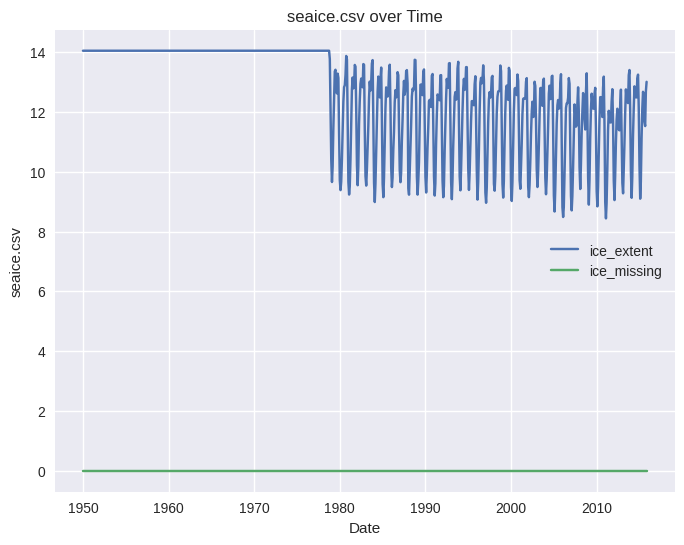

  _date_  day year month storm_type day-sin day-cos air_x air_y uwnd  co2  \
0    0.0  0.0  0.0   0.0        0.0     0.0     0.0   0.0   0.0  0.0  0.0   

  co2_seas ice_extent ice_missing  
0      0.0        0.0         0.0  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/eruptions-conditioned.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6221 entries, 0 to 6220
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              6221 non-null   int64  
 1   volcano_number          6221 non-null   int64  
 2   volcano_name            6221 non-null   object 
 3   eruption_number         6221 non-null   int64  
 4   eruption_category       6221 non-null   object 
 5   area_of_activity        2604 non-null 

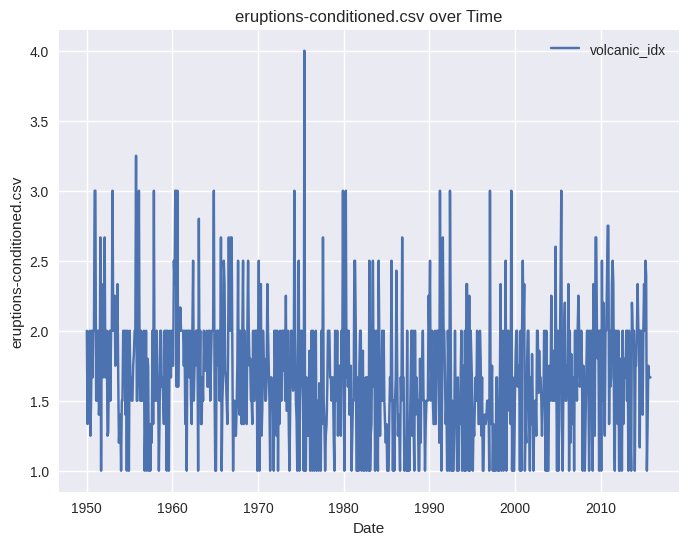

  _date_  day year month storm_type day-sin day-cos air_x air_y uwnd  co2  \
0    0.0  0.0  0.0   0.0        0.0     0.0     0.0   0.0   0.0  0.0  0.0   

  co2_seas ice_extent ice_missing volcanic_idx  
0      0.0        0.0         0.0          0.0  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/WorldForestCover-Interpolated.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              846 non-null    object 
 1   pct_forest_cover  846 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.3+ KB
------------------------------------------
 ### preprocess_dates with date_col: date
 ### Convert from given col date
------------------------

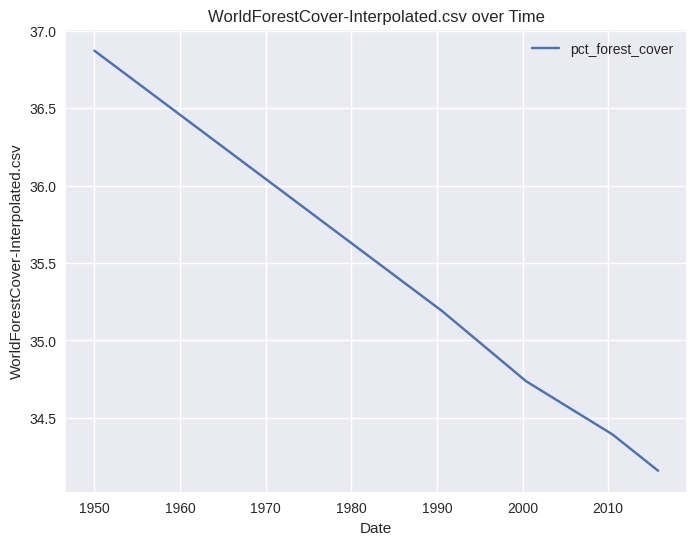

  _date_  day year month storm_type day-sin day-cos air_x air_y uwnd  co2  \
0    0.0  0.0  0.0   0.0        0.0     0.0     0.0   0.0   0.0  0.0  0.0   

  co2_seas ice_extent ice_missing volcanic_idx pct_forest_cover  
0      0.0        0.0         0.0          0.0              0.0  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/sunspotnumber.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         315 non-null    int64  
 1   sunspot_num  315 non-null    float64
 2   Unnamed: 2   0 non-null      float64
 3   Unnamed: 3   0 non-null      float64
 4   Unnamed: 4   0 non-null      float64
 5   Unnamed: 5   0 non-null      float64
 6   Unnamed: 6   0 non-null

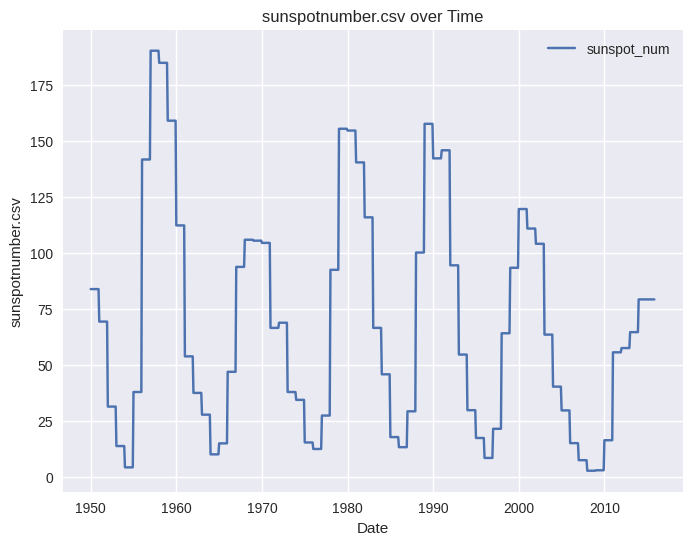

  _date_  day year month storm_type day-sin day-cos air_x air_y uwnd  co2  \
0    0.0  0.0  0.0   0.0        0.0     0.0     0.0   0.0   0.0  0.0  0.0   

  co2_seas ice_extent ice_missing volcanic_idx pct_forest_cover sunspot_num  
0      0.0        0.0         0.0          0.0              0.0         0.0  


In [17]:
for dataset in ALL_DATASETS:
  if ('date_map' in dataset):
    df_merge = merger.merge_dataset(dataset['filename'],
                                    feature_map=dataset['feature_map'],
                                    df_aggr=df_merge,
                                    date_map=dataset['date_map'])
  else:
    df_merge = merger.merge_dataset(dataset['filename'],
                                feature_map=dataset['feature_map'],
                                df_aggr=df_merge,
                                date_col=dataset['date_col'])
  print(assess_na(df_merge))

In [18]:
df_merge

,_date_,day,year,month,storm_type,day-sin,day-cos,air_x,air_y,uwnd,co2,co2_seas,ice_extent,ice_missing,volcanic_idx,pct_forest_cover,sunspot_num
0,1950-01-01,1,1950,1,169.0,0.5,0.866025,289.936261,290.994544,0.220916,315.69,314.42,14.050833,0.0,2.000000,36.872263,83.9
1,1950-02-01,1,1950,2,169.0,0.5,0.866025,289.002692,290.035596,-0.067231,315.69,314.42,14.050833,0.0,1.333333,36.868748,83.9
2,1950-03-01,1,1950,3,169.0,0.5,0.866025,297.095738,296.936238,-0.181692,315.69,314.42,14.050833,0.0,1.666667,36.865573,83.9
3,1950-04-01,1,1950,4,169.0,0.5,0.866025,302.377345,302.449196,1.313697,315.69,314.42,14.050833,0.0,1.666667,36.862058,83.9
4,1950-05-01,1,1950,5,169.0,0.5,0.866025,307.291194,307.264517,2.175056,315.69,314.42,14.050833,0.0,2.000000,36.858656,83.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2015-07-01,1,2015,7,7.0,0.5,0.866025,303.987030,304.114913,0.649732,401.60,400.76,12.576548,0.0,1.333333,34.172678,79.3
787,2015-08-01,1,2015,8,7.0,0.5,0.866025,302.203831,302.469150,1.620498,399.00,400.51,11.674048,0.0,1.750000,34.168942,79.3
788,2015-09-01,1,2015,9,27.0,0.5,0.866025,300.948820,301.557981,1.038612,397.50,400.98,11.529883,0.0,1.666667,34.165207,79.3
789,2015-10-01,1,2015,10,56.0,0.5,0.866025,298.714987,300.453620,0.634611,398.28,401.90,12.687742,0.0,1.666667,34.161592,79.3


---

**Assess correlations**

---

In [19]:
# Assess correlations between all data columns
df_corr = df_merge.corr()

In [20]:
# Identify the columns which have medium to strong correlation with target
df_corr_cols = df_corr[df_corr[TARGET_LABEL] > 0.5]

In [21]:
# Drop the target from the correlation results in case we want to use this reduced set
#    in place of the full set
df_corr_cols = df_corr_cols.drop(columns=[])

In [22]:
# Extract just the column names
corr_cols = df_corr_cols.index.values

In [23]:
if debug:
  print(corr_cols)

['storm_type']


Text(0.5, 1.0, 'Heatmap of correlation among variables')

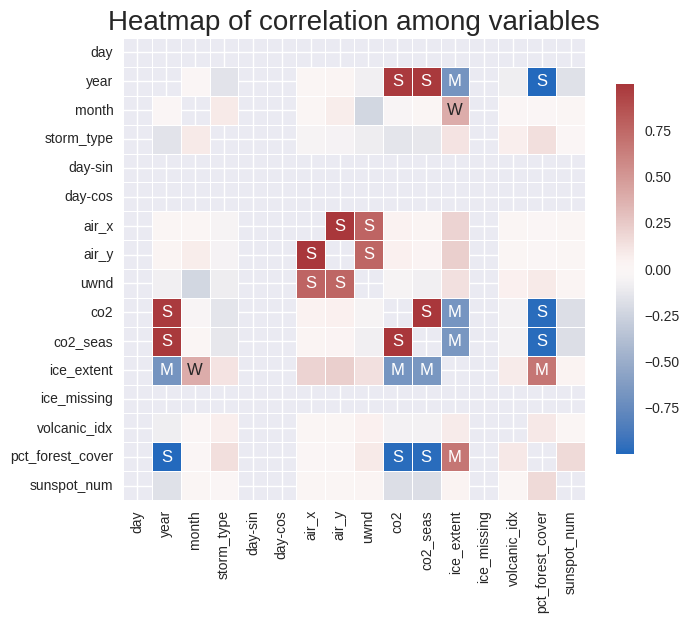

In [24]:
# Add labels
labels = np.where(np.abs(df_corr) > 0.75, 'S',
                  np.where(np.abs(df_corr) > 0.5, 'M',
                           np.where(np.abs(df_corr) > 0.25, 'W', '')))
# Plot the matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt = '', linewidths = .5,
            cmap='vlag', cbar_kws={'shrink':0.8});
plt.title('Heatmap of correlation among variables', fontsize=20)

---

**Prepare for Modeling**

---

In [25]:
# It's time to set date as index and remove from dataset
df_merge.set_index(merger.DATE_COL, inplace=True, drop=True)

In [26]:
df_merge

,day,year,month,storm_type,day-sin,day-cos,air_x,air_y,uwnd,co2,co2_seas,ice_extent,ice_missing,volcanic_idx,pct_forest_cover,sunspot_num
_date_,,,,,,,,,,,,,,,,
1950-01-01,1,1950,1,169.0,0.5,0.866025,289.936261,290.994544,0.220916,315.69,314.42,14.050833,0.0,2.000000,36.872263,83.9
1950-02-01,1,1950,2,169.0,0.5,0.866025,289.002692,290.035596,-0.067231,315.69,314.42,14.050833,0.0,1.333333,36.868748,83.9
1950-03-01,1,1950,3,169.0,0.5,0.866025,297.095738,296.936238,-0.181692,315.69,314.42,14.050833,0.0,1.666667,36.865573,83.9
1950-04-01,1,1950,4,169.0,0.5,0.866025,302.377345,302.449196,1.313697,315.69,314.42,14.050833,0.0,1.666667,36.862058,83.9
1950-05-01,1,1950,5,169.0,0.5,0.866025,307.291194,307.264517,2.175056,315.69,314.42,14.050833,0.0,2.000000,36.858656,83.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-01,1,2015,7,7.0,0.5,0.866025,303.987030,304.114913,0.649732,401.60,400.76,12.576548,0.0,1.333333,34.172678,79.3
2015-08-01,1,2015,8,7.0,0.5,0.866025,302.203831,302.469150,1.620498,399.00,400.51,11.674048,0.0,1.750000,34.168942,79.3
2015-09-01,1,2015,9,27.0,0.5,0.866025,300.948820,301.557981,1.038612,397.50,400.98,11.529883,0.0,1.666667,34.165207,79.3


**Assess Periodicity**

```
# removed kendalltau analysis
# Replace with fft graph of major freqs?
```


**Resampling**

This is being performed during the dataset merging phase.

Ready for time series modeling.

---

**Data conversion for model**

---

**Extract labels**

Time series creates a supervised learning problem out of moving data.

**Dataset stats**

In [27]:
NUM_FEATURES = len(df_merge.columns)

# Capture stats on number of non-metadata columns - so, exclude some stuff
#NET_NUM_FEATURES = len(set(df_merge.columns) - set(['year','month','day']))

In [28]:
# Keep rows aside for post validation?
TOTAL_ROWS = df_merge.shape[0]
NUM_VALIDATION = math.floor(TOTAL_ROWS * VALIDATION_RATIO)
WORKING_ROWS = TOTAL_ROWS - NUM_VALIDATION

In [29]:
# Split non-validation rows into train/test
NUM_TEST = math.floor(WORKING_ROWS * TEST_RATIO)
NUM_TRAIN = WORKING_ROWS - NUM_TEST

In [30]:
print(f'Num features: {NUM_FEATURES}')
print(f'Total rows: {TOTAL_ROWS}')
print(f'Validation rows: {NUM_VALIDATION}')
print(f'Train rows: {NUM_TRAIN}')
print(f'Test rows: {NUM_TEST}')

Num features: 16
Total rows: 791
Validation rows: 79
Train rows: 570
Test rows: 142


**Split into Train/Test**

In [31]:
df_train = df_merge.iloc[:NUM_TRAIN, :]
df_val = df_merge.iloc[NUM_TRAIN:NUM_TRAIN+NUM_VALIDATION, :]
df_test = df_merge.iloc[NUM_TRAIN+NUM_VALIDATION:, :]

In [32]:
y_train = df_train[TARGET_LABEL]
y_val = df_val[TARGET_LABEL]
y_test = df_test[TARGET_LABEL]

In [33]:
if debug:
  print(f'df_train: {df_train.shape}')
  print(f'y_train: {y_train.shape}')
  print(f'df_test: {df_test.shape}')
  print(f'y_test: {y_test.shape}')
  print(f'df_val: {df_val.shape}')
  print(f'y_val: {y_val.shape}')

df_train: (570, 16)
y_train: (570,)
df_test: (142, 16)
y_test: (142,)
df_val: (79, 16)
y_val: (79,)


**Scale data**

Doing this **after** the split means that training data doesn't get unfair advantage of looking ahead into the 'future' during test & validation.

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [35]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer,  QuantileTransformer, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import tensorflow as tf


In [36]:
# Create small pipeline for numerical features
numeric_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy='mean')),
                                    ('scale', MinMaxScaler())])

In [37]:
# get names of numerical features
con_lst = df_train.select_dtypes(include='number').columns.to_list()

In [38]:
# Transformer for applying Pipelines
column_transformer = ColumnTransformer(transformers = [('number', numeric_pipeline, con_lst)])

In [39]:
# Transform data features
X_train_tx = column_transformer.fit_transform(df_train)
X_test_tx = column_transformer.transform(df_test)
X_val_tx = column_transformer.transform(df_val)
X_train_tx.shape, X_test_tx.shape, X_val_tx.shape

((570, 16), (142, 16), (79, 16))

In [40]:
# Transform labels
label_scaler = MinMaxScaler()
y_train_tx = label_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [41]:
# Slice labels - we cannot predict anything inside the first INPUT_WINDOW
#y_train_tx = y_train_tx[INPUT_WINDOW:]

In [42]:
if debug:
  print(f'X_train_tx {X_train_tx.shape}: {X_train_tx[0]}')
  print(f'y_train_tx {y_train_tx.shape}: {y_train_tx[0]}')

X_train_tx (570, 16): [0.         0.         0.         0.48837209 0.         0.
 0.19365674 0.1762533  0.33617958 0.04627729 0.         1.
 0.         0.33333333 1.         0.42787944]
y_train_tx (570, 1): [0.48837209]


**Extract X and y**

Normally we would do this by explicitly extracting data from our df.

However for a time series, we're going to create many small supervised learning sets, so a set of X and y pairs.

We should end up with data in a shape ready for batched network input:

`batches X time_steps X features`



In [43]:
if debug:
  print(f'X_train_tx: {X_train_tx.shape}')
  print(f'y_train_tx: {y_train_tx.shape}')

X_train_tx: (570, 16)
y_train_tx: (570, 1)


In [44]:
NUM_LABELS = y_train_tx.shape[1]

---

**Modeling**

---

In [45]:
# These are the features we are going to be modeling
COLS = list(df_merge.columns)

**Slice into Batches**

In [46]:
windower = TfWindowGenerator(input_width=INPUT_WINDOW,
                             label_width=LABEL_WINDOW,
                             shift=SHIFT,
                             batch_size=INPUT_WINDOW,
                             debug=False)

In [47]:
windower

Window Generator::
	Input size: 60
	Label size: 48
	Shift: 1
	Batch size: 60
	Total window size: 108
	Label start: 60

In [48]:
X_train_tx.shape, y_train_tx.shape

((570, 16), (570, 1))

In [49]:
ds = windower.get_ds_from_arrays(X_train_tx, y_train_tx)

input_arr: (570, 16)
label_arr: (570, 1)
## Inputs: (463, 60, 16)
## Labels: (463, 48, 1)


In [50]:
# Use tensorflow util to batch the timeseries
# #   note that targets assume first label starts at 0 (vs. targets[INPUT_WINDOW])
# ds = tf.keras.utils.timeseries_dataset_from_array(
#     data=X_train_tx,
#     targets=y_train_tx,
#     batch_size=INPUT_WINDOW*2,
#     sequence_length=INPUT_WINDOW )

In [52]:
for i,batch in enumerate(ds):
  X,y = batch
  print(f'batch size: {X.shape},{y.shape}')
  if (i == 0):
    print(f'----------- X -------------\n{X[0][0]}')
    print(f'{y[0][0]}')
  break

batch size: (60, 60, 16),(60, 48, 1)
----------- X -------------
[0.         0.         0.         0.4883721  0.         0.
 0.19365674 0.1762533  0.33617958 0.04627729 0.         1.
 0.         0.33333334 1.         0.42787945]
[0.27325583]


**Prep GPU**

In [53]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


---

**Build and Train**

---

**Build model**

In [54]:
# Load model class
%run -i "./Model_Base.ipynb"

In [55]:
%run -i "./ModelFactory.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data606/src
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data606/src
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data606/src
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data606/src


In [56]:
# Use factory for flexible selection
mf = ModelFactory(window_size=INPUT_WINDOW,label_window=LABEL_WINDOW,num_labels=NUM_LABELS,num_epochs=NUM_EPOCHS,debug=True)

### Building ModelDensev1::
### Building ModelLSTMv3::
### Building ModelTXERv1::


In [57]:
mf

window_size: 60
label_window: 48
num_labels: 1
num_epochs: 300

In [58]:
print(f'Initializing model: {MODEL_NAME}')
model = mf.get(MODEL_NAME)

Initializing model: LSTMv3


In [59]:
model

Model: LSTMv3
	window_size: 60
	label_window: 48
	num_labels: 1
	num_epochs: 300
	alpha: 0.0001

**Train model**

In [60]:
model_history = model.train(dataset=ds, num_features=NUM_FEATURES)

Epoch 1/300
8/8 [==============================] - 11s 14ms/step - loss: 0.1872
Epoch 2/300
8/8 [==============================] - 0s 7ms/step - loss: 0.1541
Epoch 3/300
8/8 [==============================] - 0s 7ms/step - loss: 0.1523
Epoch 4/300
8/8 [==============================] - 0s 6ms/step - loss: 0.1465
Epoch 5/300
8/8 [==============================] - 0s 7ms/step - loss: 0.1424
Epoch 6/300
8/8 [==============================] - 0s 6ms/step - loss: 0.1433
Epoch 7/300
8/8 [==============================] - 0s 6ms/step - loss: 0.1367
Epoch 8/300
8/8 [==============================] - 0s 9ms/step - loss: 0.1358
Epoch 9/300
8/8 [==============================] - 0s 6ms/step - loss: 0.1350
Epoch 10/300
8/8 [==============================] - 0s 7ms/step - loss: 0.1347
Epoch 11/300
8/8 [==============================] - 0s 9ms/step - loss: 0.1341
Epoch 12/300
8/8 [==============================] - 0s 6ms/step - loss: 0.1334
Epoch 13/300
8/8 [==============================] - 0s 6ms/

In [61]:
# Capture stat
num_epochs = len(model_history.history['loss'])

**Test Predictions**

In [62]:
num_predictions = y_test.shape[0]-INPUT_WINDOW-LABEL_WINDOW
print(f'Num Exp. Predictions: {num_predictions} == {y_test.shape[0]} - {INPUT_WINDOW}')

preds = []
pred_dates = []
y_test_vals = []

Num Exp. Predictions: 34 == 142 - 60


In [63]:
# Defaults to a single Day
STEP_OFFSET = pd.DateOffset()

if (STEP_FREQ == 'M'):
  STEP_OFFSET = pd.DateOffset(months=1)
else:
  STEP_OFFSET = pd.DateOffset(years=1)

In [64]:
for p in range(num_predictions):
  # Prepare inputs
  print(f'Pred range: x_test_tx[{p}:{p+INPUT_WINDOW}]')
  X_pred = X_test_tx[p:p+INPUT_WINDOW,:].reshape(-1, INPUT_WINDOW, NUM_FEATURES)

  # Prepare outputs
  label_start_index = p+INPUT_WINDOW
  print(f'Exp output: y_test[{label_start_index}:{label_start_index + LABEL_WINDOW}]')
  y_test_vals.append(y_test[label_start_index:label_start_index + LABEL_WINDOW])

  if (LABEL_WINDOW == 1):
    print(f'Pred date: {df_test.index[label_start_index]}')
  else:
    print(f'Pred dates: {df_test.index[label_start_index]} + {LABEL_WINDOW-1} steps')

  # Predict
  batch_preds = model.predict(X_pred)
  print(f'## Batch step: {batch_preds.shape}')
  if (len(batch_preds.shape) > 2):
    #batch_preds = batch_preds[0]
    batch_preds = batch_preds.reshape(LABEL_WINDOW, -1)

  # Re-Scale
  pred_vals = label_scaler.inverse_transform(batch_preds)
  # Reduce to single array
  pred_vals = np.squeeze(pred_vals)

  # if (len(pred_vals.shape) > 1):
  #   #pred_vals = pred_vals.reshape(-1)
  #   pred_vals = pred_vals.ravel()
  print(f'## Pred vals: {pred_vals.shape}\n{pred_vals}')

  if (LABEL_WINDOW == 1):
    preds.append(pred_vals.ravel())
    pred_dates.append(df_test.index[label_start_index])
  else:
    # Add one row per label output; we need to increment the date manually
    pred_start_date = df_test.index[label_start_index]
    step_date = pred_start_date
    for val in pred_vals.tolist():
      # add current result values
      print(f'## val:  type: {type(val)}  value: {val}')
      preds.append(val)
      pred_dates.append(step_date)
      print(f'## Pred: {step_date} {val}')
      # move to next step
      step_date = (step_date + STEP_OFFSET)

Pred range: x_test_tx[0:60]
Exp output: y_test[60:108]
Pred dates: 2009-02-01 00:00:00 + 47 steps
1/1 [==============================] - 0s 418ms/step
## Batch step: (1, 48, 1)
## Pred vals: (48,)
[ 81.71085    67.90504    83.10908    47.288597   23.993597   36.64371
  76.51979    92.971054   77.94867    25.11222    16.750496   19.408278
  62.84697    60.53353    50.17859    37.974342    2.344984   -5.867955
  18.048153   31.38136    32.106163   91.78862    78.46601    58.66323
  57.62412    91.89333    77.796104   58.669903   39.817436   24.234446
  32.156258  112.64666    72.37354   109.928246  126.06636   107.071495
  97.48788    62.7934     72.85823    28.67094    19.389357    3.7622886
  38.60283    46.594727   52.217274   67.25134   116.11043   122.69812  ]
## val:  type: <class 'float'>  value: 81.71085357666016
## Pred: 2009-02-01 00:00:00 81.71085357666016
## val:  type: <class 'float'>  value: 67.90503692626953
## Pred: 2009-03-01 00:00:00 67.90503692626953
## val:  type: <cl

In [65]:
df_all_results = pd.DataFrame({'preds': np.squeeze(preds),
                               'pred_dates':pred_dates
                            })

In [66]:
if (LABEL_WINDOW != SHIFT):
  # There is probably overlap of output due to this condition
  #   Combine predicted outputs for the same dates
  df_results = df_all_results.groupby(['pred_dates']).mean()
else:
  df_results = df_all_results

In [67]:
# Move dates out of column and into index, if it exists
if ('pred_dates' in df_results.columns):
  df_results.set_index('pred_dates', drop=True, inplace=True)

In [68]:
# Reduce df_test to just the columns and dates necessary
df_y = df_retain(df_test, TARGET_LABELS)
df_y = df_y[df_results.index.min():df_results.index.max()]

In [69]:
# And merge y values into preds
df_results = df_y.merge(df_results, how='inner', left_index=True, right_index=True, suffixes=['', '_dft'])
df_results = df_results.rename({TARGET_LABEL:'y_test'}, axis=1)

In [70]:
# Finally, reduce to a simple index to make the graphing work nicely
df_results.reset_index(inplace=True, drop=False, names='pred_dates')
# But we need a date label col
date_labels = df_results['pred_dates'].apply(lambda x: x.strftime('%Y-%m-%d')).values
# and now we can drop it
df_results.drop(columns=['pred_dates'], inplace=True)

In [71]:
df_results

,y_test,preds
0,72.0,81.710854
1,72.0,81.562267
2,72.0,72.550070
3,12.0,46.131588
4,12.0,40.412922
...,...,...
76,40.0,26.685880
77,7.0,42.724863
78,7.0,76.208586
79,27.0,94.297112


**Analyze results**

Text(0, 0.5, 'Predicted values')

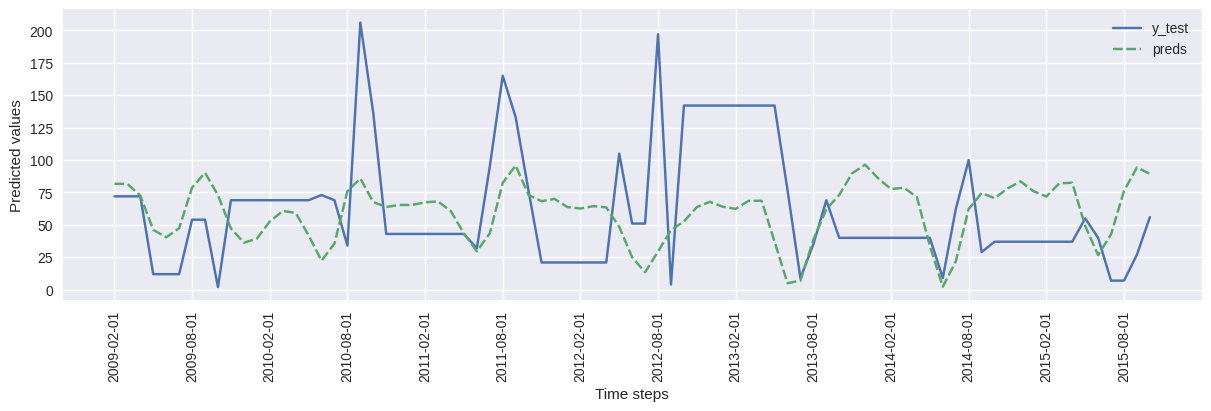

In [72]:
# Plot results
# max points - default to full set
TICK_SPACING=6
fig, ax = plt.subplots(figsize=(12,4), layout="constrained")
sns.lineplot(data=df_results, ax=ax)
ax.set_xticks(df_results.index, labels=date_labels, rotation=90)
ax.xaxis.set_major_locator(plticker.MultipleLocator(TICK_SPACING))
plt.xlabel('Time steps')
plt.ylabel('Predicted values')
#plt.legend(('Test','Predicted'))

**Error Calculations**

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [86]:
y_test_vals = df_results['y_test'].values
preds = df_results['preds'].values

In [87]:
# y_test_vals = y_test_vals.reshape(y_test_vals.shape[0],1)
# preds = preds.reshape(preds.shape[0],1)
# y_test_vals.shape, preds.shape

In [88]:
# Calculate MAPE
m = tf.keras.metrics.MeanAbsolutePercentageError()
try:
  m.update_state(y_test_vals, preds)
except ValueError as ve:
  print(f'ValueError calculating MAPE: {ve}')

In [89]:
mse = mean_squared_error(y_test_vals, preds)
mae = mean_absolute_error(y_test_vals, preds)
mape = m.result().numpy()/100  # adjust Keras output to match scikit
from sklearn.metrics import mean_absolute_percentage_error
sk_mape = mean_absolute_percentage_error(y_test_vals, preds)

In [90]:
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'SKMAPE: {sk_mape}')

MSE: 2312.0531316820634
MAE: 40.04761839933006
MAPE: 1.527854461669922
SKMAPE: 1.5278544459914534


**Journal entry**

In [91]:
import csv

In [92]:
def current_time_ms():
  return dt.now().microsecond

In [93]:
serial = current_time_ms()

In [94]:
# write pred results out
df_results.to_csv(LOG_PATH +  f'model-preds-{serial}.csv', index_label='index')

In [95]:
# Save model
model.save_model(LOG_PATH, serial)

Saving model to: /content/drive/MyDrive/data606/data//preds/20231129-0023-LSTMv3-772157.hdf5


In [96]:
with open(JOURNAL_LOG, 'a') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(['DateTime','Serial','Model','TargetLabel','NumFeatures','WindowSize','TestPct','NumEpochs','MSE','MAE','MAPE','SKMAPE','Columns'])
  writer.writerow([dt.today().strftime("%Y%m%d-%H%M"),serial,MODEL_NAME,TARGET_LABEL,NUM_FEATURES,INPUT_WINDOW,TEST_RATIO,num_epochs,mse,mae,mape,sk_mape,COLS])